In [5]:
import os, pathlib

p = pathlib.Path("/content/drive")
print("exists:", p.exists(), "is_dir:", p.is_dir())
if p.exists():
    print("contents (first 50):", [x.name for x in list(p.iterdir())[:50]])

exists: True is_dir: True
contents (first 50): ['MyDrive']


In [6]:
import os, shutil, pathlib
from google.colab import drive

# If it exists and has anything inside, delete it
p = pathlib.Path("/content/drive")
if p.exists():
    # Safety: only delete if it's not already a proper mount
    if not os.path.ismount("/content/drive"):
        shutil.rmtree("/content/drive", ignore_errors=True)

# Recreate empty mountpoint
os.makedirs("/content/drive", exist_ok=True)

# Now mount
drive.mount("/content/drive", force_remount=True)

print("Mounted:", os.path.ismount("/content/drive"))
print("MyDrive exists:", os.path.exists("/content/drive/MyDrive"))

Mounted at /content/drive
Mounted: True
MyDrive exists: True


In [7]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path("/content/drive/MyDrive/pairs_trading_project")
STATS_DIR = PROJECT_ROOT / "results" / "statistics"
FIG_DIR   = PROJECT_ROOT / "results" / "figures"
OUT_DIR   = PROJECT_ROOT / "results" / "phase7"
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

expected = STATS_DIR / "pair_returns_after_costs.csv"

if expected.exists():
    path = expected
else:
    hits = list(PROJECT_ROOT.rglob("pair_returns_after_costs.csv"))
    if not hits:
        raise FileNotFoundError(
            "pair_returns_after_costs.csv not found under pairs_trading_project.\n"
            "Re-run the phase that generates it, or confirm the filename."
        )
    path = hits[0]

print("Loading:", path)

rets = pd.read_csv(path, index_col=0, parse_dates=True).sort_index()

# Ensure it's numeric
rets = rets.apply(pd.to_numeric, errors="coerce")

display(rets.head())
print("Shape:", rets.shape)
print("Date range:", rets.index.min(), "→", rets.index.max())
print("Pairs:", rets.columns[:10].tolist(), "..." if rets.shape[1] > 10 else "")

Loading: /content/drive/MyDrive/pairs_trading_project/results/statistics/pair_returns_after_costs.csv


,EOG_FANG,FCX_GOLD,V_MA
date,,,
2017-01-04,0.0,0.0,0.0
2017-01-05,0.0,0.0,0.0
2017-01-06,0.0,0.0,0.0
2017-01-09,0.0,0.0,0.0
2017-01-10,0.0,0.0,0.0


Shape: (2295, 3)
Date range: 2017-01-04 00:00:00 → 2026-02-20 00:00:00
Pairs: ['EOG_FANG', 'FCX_GOLD', 'V_MA'] 


In [8]:
import numpy as np

# Equal-weight portfolio across pairs each day (skip NaNs)
port_ret = rets.mean(axis=1, skipna=True).rename("portfolio_return")

# Drop days where everything is NaN
port_ret = port_ret.dropna()

print("Portfolio points:", len(port_ret))
display(port_ret.head())

Portfolio points: 2295


,portfolio_return
date,
2017-01-04,0.0
2017-01-05,0.0
2017-01-06,0.0
2017-01-09,0.0
2017-01-10,0.0


In [9]:
TRADING_DAYS = 252

def perf_stats(r: pd.Series) -> pd.Series:
    r = r.dropna()
    if len(r) < 5:
        return pd.Series(dtype=float)

    mean_d = r.mean()
    vol_d  = r.std(ddof=1)
    ann_ret = (1 + mean_d) ** TRADING_DAYS - 1
    ann_vol = vol_d * np.sqrt(TRADING_DAYS)
    sharpe  = (mean_d / vol_d) * np.sqrt(TRADING_DAYS) if vol_d > 0 else np.nan

    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1
    max_dd = dd.min()

    # Hit rate + skew/kurt
    hit = (r > 0).mean()
    skew = r.skew()
    kurt = r.kurtosis()

    return pd.Series({
        "start": r.index.min(),
        "end": r.index.max(),
        "n_days": len(r),
        "mean_daily": mean_d,
        "vol_daily": vol_d,
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "hit_rate": hit,
        "max_drawdown": max_dd,
        "skew": skew,
        "kurtosis": kurt,
        "total_return": wealth.iloc[-1] - 1
    })

stats_port = perf_stats(port_ret)
display(stats_port.to_frame("portfolio").T)

,start,end,n_days,mean_daily,vol_daily,ann_return,ann_vol,sharpe,hit_rate,max_drawdown,skew,kurtosis,total_return
portfolio,2017-01-04 00:00:00,2026-02-20 00:00:00,2295,0.000008,0.000716,0.001909,0.011363,0.167799,0.023529,-0.02639,11.930972,441.795307,0.016922


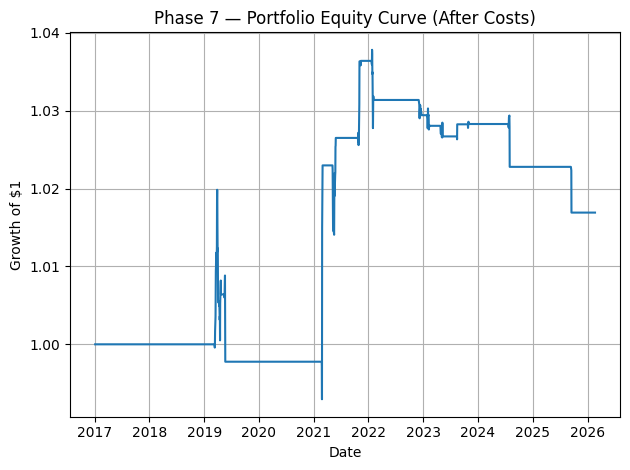

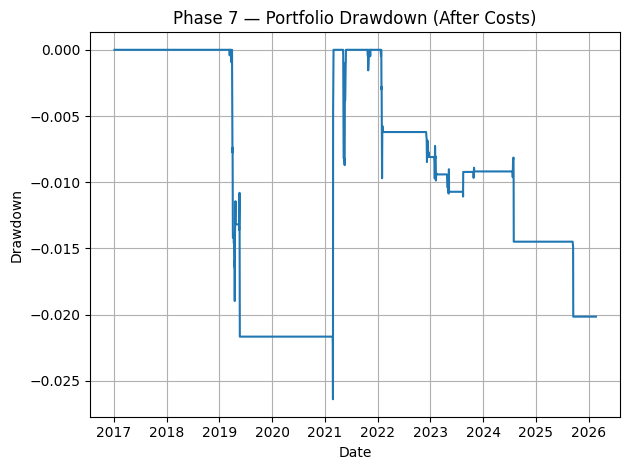

Saved figures to: /content/drive/MyDrive/pairs_trading_project/results/figures


In [10]:
import matplotlib.pyplot as plt

wealth = (1 + port_ret).cumprod()
peak = wealth.cummax()
drawdown = wealth / peak - 1

# Equity curve
plt.figure()
plt.plot(wealth.index, wealth.values)
plt.title("Phase 7 — Portfolio Equity Curve (After Costs)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "phase7_equity_curve.png", dpi=160)
plt.show()

# Drawdown
plt.figure()
plt.plot(drawdown.index, drawdown.values)
plt.title("Phase 7 — Portfolio Drawdown (After Costs)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "phase7_drawdown.png", dpi=160)
plt.show()

print("Saved figures to:", FIG_DIR)

In [13]:
# Total contribution per pair = sum of daily returns (simple), and compounded growth per pair
pair_sum = rets.sum(axis=0, skipna=True).sort_values(ascending=False)
pair_growth = (1 + rets.fillna(0)).prod(axis=0) - 1
pair_growth = pair_growth.sort_values(ascending=False)

contrib = pd.DataFrame({
    "sum_returns": pair_sum,
    "compounded_return": pair_growth
}).sort_values("sum_returns", ascending=False)

display(contrib.head(15))
display(contrib.tail(15))

,sum_returns,compounded_return
EOG_FANG,0.141437,0.147681
V_MA,-0.029571,-0.029353
FCX_GOLD,-0.059770,-0.059199


,sum_returns,compounded_return
EOG_FANG,0.141437,0.147681
V_MA,-0.029571,-0.029353
FCX_GOLD,-0.059770,-0.059199


In [14]:
import numpy as np
import pandas as pd

# portfolio
zero_port = (port_ret == 0).mean()
nz_port = (port_ret != 0).mean()
print("Portfolio % zero:", round(zero_port*100, 2))
print("Portfolio % non-zero:", round(nz_port*100, 2))

# per pair
nz_by_pair = (rets != 0).sum().sort_values(ascending=False)
print("\nNon-zero days per pair:")
display(nz_by_pair.to_frame("nonzero_days"))

print("\nNon-zero fraction per pair:")
display(((rets != 0).mean().sort_values(ascending=False)).to_frame("nonzero_frac"))

Portfolio % zero: 95.29
Portfolio % non-zero: 4.71

Non-zero days per pair:


,nonzero_days
EOG_FANG,48
V_MA,40
FCX_GOLD,24



Non-zero fraction per pair:


,nonzero_frac
EOG_FANG,0.020915
V_MA,0.017429
FCX_GOLD,0.010458


In [15]:
nz = port_ret[port_ret != 0]
print("Non-zero count:", len(nz))
print(nz.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

# biggest absolute moves
display(nz.reindex(nz.abs().sort_values(ascending=False).head(20).index).to_frame("largest_abs_moves"))

Non-zero count: 108
count    108.000000
mean       0.000161
std        0.003311
min       -0.007746
1%        -0.007676
5%        -0.005121
50%       -0.000018
95%        0.004583
99%        0.007723
max        0.022223
Name: portfolio_return, dtype: float64


,largest_abs_moves
date,
2021-02-26,0.022223
2021-03-01,0.007861
2019-04-01,-0.007746
2021-05-10,-0.007686
2019-05-21,-0.007532
2022-01-31,-0.006930
2019-03-28,0.005885
2021-11-02,0.005353
2025-09-16,-0.005314


In [16]:
from pathlib import Path

cands = []
for name in [
    "pair_returns.csv",
    "pair_returns_gross.csv",
    "pair_returns_before_costs.csv",
    "pair_returns_pre_costs.csv",
    "pair_returns_raw.csv",
]:
    hits = list(PROJECT_ROOT.rglob(name))
    cands += hits

print("Candidates:")
for h in cands:
    print(h)

Candidates:


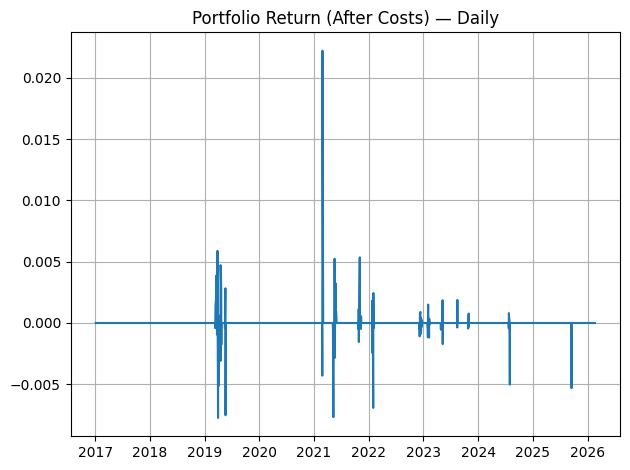

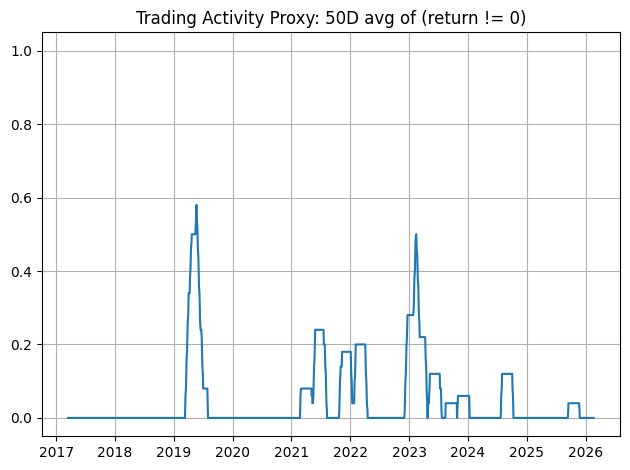

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(port_ret.index, port_ret.values)
plt.title("Portfolio Return (After Costs) — Daily")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot((port_ret != 0).astype(int).rolling(50).mean())
plt.title("Trading Activity Proxy: 50D avg of (return != 0)")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from pathlib import Path

needles = [
    "positions", "position", "weights", "weight", "signals", "signal",
    "spread", "zscore", "z_score", "beta", "hedge", "cost", "fees",
    "pair_returns"
]

hits = {}
for n in needles:
    hits[n] = list(PROJECT_ROOT.rglob(f"*{n}*.csv"))

for k, v in hits.items():
    if v:
        print(f"\n== {k} ==")
        for p in v[:20]:
            print(p)


== signals ==
/content/drive/MyDrive/pairs_trading_project/data/features/signals/signals_EOG_FANG.csv
/content/drive/MyDrive/pairs_trading_project/data/features/signals/signals_V_MA.csv
/content/drive/MyDrive/pairs_trading_project/data/features/signals/signals_FCX_GOLD.csv

== signal ==
/content/drive/MyDrive/pairs_trading_project/data/features/signals/signals_EOG_FANG.csv
/content/drive/MyDrive/pairs_trading_project/data/features/signals/signals_V_MA.csv
/content/drive/MyDrive/pairs_trading_project/data/features/signals/signals_FCX_GOLD.csv
/content/drive/MyDrive/pairs_trading_project/results/statistics/signal_quality_counterfactual_by_regime.csv
/content/drive/MyDrive/pairs_trading_project/results/statistics/signal_quality_by_regime.csv

== beta ==
/content/drive/MyDrive/pairs_trading_project/results/statistics/cointegration_oos_validation_rollingbeta_v2.csv
/content/drive/MyDrive/pairs_trading_project/results/statistics/pairs_passed_phase35_rollingbeta_v2.csv

== cost ==
/content/d

In [20]:
from pathlib import Path
import pandas as pd
import numpy as np

SIG_DIR = PROJECT_ROOT / "data" / "features" / "signals"
pair_names = ["EOG_FANG", "FCX_GOLD", "V_MA"]

signals = {}
for pair in pair_names:
    fp = SIG_DIR / f"signals_{pair}.csv"
    df = pd.read_csv(fp, parse_dates=True)

    # Try to find the date column
    date_col = None
    for c in ["date", "Date", "datetime", "time", "timestamp"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        # assume first column is date-like
        date_col = df.columns[0]

    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).sort_index()

    # Print columns so we know what we have
    print(f"\n{pair} columns:\n", df.columns.tolist())

    signals[pair] = df

# Align on common date index across pairs
common_idx = None
for pair, df in signals.items():
    common_idx = df.index if common_idx is None else common_idx.intersection(df.index)

print("\nCommon index range:", common_idx.min(), "→", common_idx.max(), "len:", len(common_idx))


EOG_FANG columns:
 ['spread', 'half_life_roll', 'mean_crossings_roll', 'adf_p_roll', 'mr_regime_v2', 'mr_regime_adf', 'mr_regime_final', 'z', 'max_hold_days', 'pos', 'entry', 'exit', 'hold_days', 'cooldown', 'spread_chg', 'pnl_spread_units']

FCX_GOLD columns:
 ['spread', 'half_life_roll', 'mean_crossings_roll', 'adf_p_roll', 'mr_regime_v2', 'mr_regime_adf', 'mr_regime_final', 'z', 'max_hold_days', 'pos', 'entry', 'exit', 'hold_days', 'cooldown', 'spread_chg', 'pnl_spread_units']

V_MA columns:
 ['spread', 'half_life_roll', 'mean_crossings_roll', 'adf_p_roll', 'mr_regime_v2', 'mr_regime_adf', 'mr_regime_final', 'z', 'max_hold_days', 'pos', 'entry', 'exit', 'hold_days', 'cooldown', 'spread_chg', 'pnl_spread_units']

Common index range: 2016-01-04 00:00:00 → 2026-02-20 00:00:00 len: 2548


In [21]:
import numpy as np
import pandas as pd

def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    # try case-insensitive match
    lower = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower:
            return lower[c.lower()]
    return None

pair_daily_returns = []
pair_positions = []

for pair, df in signals.items():
    df = df.reindex(common_idx).copy()

    # 1) pick signal-like column
    sig_col = pick_col(df.columns, ["signal", "position", "pos", "trade_signal", "side"])
    if sig_col is None:
        # sometimes entry/exit columns exist; try to infer later
        raise ValueError(f"{pair}: couldn't find a signal/position column. Columns={df.columns.tolist()}")

    sig = pd.to_numeric(df[sig_col], errors="coerce").fillna(0.0)

    # normalize signal to -1/0/+1
    sig = np.sign(sig)

    # persist position day to day (if signal is 0, we go flat; if you want 'hold' logic, change this)
    pos = sig.copy()

    # 2) pick spread-like column
    spr_col = pick_col(df.columns, ["spread", "pair_spread", "residual", "log_spread", "y_minus_beta_x", "s"])
    if spr_col is None:
        # fallback: use zscore as a proxy (not ideal, but better than nothing)
        spr_col = pick_col(df.columns, ["zscore", "z_score", "z"])
    if spr_col is None:
        raise ValueError(f"{pair}: couldn't find spread or zscore column. Columns={df.columns.tolist()}")

    spr = pd.to_numeric(df[spr_col], errors="coerce")
    ds = spr.diff()

    # daily return proxy: position(t-1) * delta(spread)
    # This is "PnL in spread units"; to turn into returns, scale by spread volatility proxy
    pnl = pos.shift(1).fillna(0.0) * ds

    # scale to a return-like series (avoid division by 0)
    scale = spr.rolling(60, min_periods=20).std().replace(0, np.nan)
    ret = (pnl / scale).fillna(0.0)

    pair_daily_returns.append(ret.rename(pair))
    pair_positions.append(pos.rename(pair))

rets_rebuilt = pd.concat(pair_daily_returns, axis=1).fillna(0.0)
pos_rebuilt  = pd.concat(pair_positions, axis=1).fillna(0.0)

# Save
rebuilt_rets_path = OUT_DIR / "pair_returns_REBUILT_from_signals.csv"
rebuilt_pos_path  = OUT_DIR / "pair_positions_REBUILT_from_signals.csv"
rets_rebuilt.to_csv(rebuilt_rets_path)
pos_rebuilt.to_csv(rebuilt_pos_path)

print("Saved:", rebuilt_rets_path)
print("Saved:", rebuilt_pos_path)

# sanity check
port_rebuilt = rets_rebuilt.mean(axis=1)
print("Rebuilt portfolio % zero:", (port_rebuilt == 0).mean())
print("Rebuilt portfolio non-zero days:", (port_rebuilt != 0).sum(), "of", len(port_rebuilt))

display(rets_rebuilt.head())
display(pos_rebuilt.head())

Saved: /content/drive/MyDrive/pairs_trading_project/results/phase7/pair_returns_REBUILT_from_signals.csv
Saved: /content/drive/MyDrive/pairs_trading_project/results/phase7/pair_positions_REBUILT_from_signals.csv
Rebuilt portfolio % zero: 0.9642857142857143
Rebuilt portfolio non-zero days: 91 of 2548


,EOG_FANG,FCX_GOLD,V_MA
Unnamed: 0,,,
2016-01-04,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0
2016-01-06,0.0,0.0,0.0
2016-01-07,0.0,0.0,0.0
2016-01-08,0.0,0.0,0.0


,EOG_FANG,FCX_GOLD,V_MA
Unnamed: 0,,,
2016-01-04,0,0,0
2016-01-05,0,0,0
2016-01-06,0,0,0
2016-01-07,0,0,0
2016-01-08,0,0,0


In [22]:
from pathlib import Path
import pandas as pd
import numpy as np

SIG_DIR = PROJECT_ROOT / "data" / "features" / "signals"
pair_names = ["EOG_FANG", "FCX_GOLD", "V_MA"]

pnl = []
pos = []
spr = []

for pair in pair_names:
    fp = SIG_DIR / f"signals_{pair}.csv"
    df = pd.read_csv(fp, parse_dates=True)

    # date col is first col in your files ("Unnamed: 0" got created in previous save)
    date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).sort_index()

    # pull columns
    pnl.append(pd.to_numeric(df["pnl_spread_units"], errors="coerce").fillna(0.0).rename(pair))
    pos.append(pd.to_numeric(df["pos"], errors="coerce").fillna(0.0).rename(pair))
    spr.append(pd.to_numeric(df["spread"], errors="coerce").rename(pair))

pnl = pd.concat(pnl, axis=1).sort_index()
pos = pd.concat(pos, axis=1).sort_index()
spr = pd.concat(spr, axis=1).sort_index()

# Convert PnL-in-spread-units into a return-like number by scaling with spread level/vol proxy.
# Better than nothing without price-level notional.
scale = spr.rolling(60, min_periods=20).std().replace(0, np.nan)
rets_daily = (pnl / scale).fillna(0.0)

# Save
rets_path = OUT_DIR / "pair_returns_DAILY_from_pnl_spread_units.csv"
pos_path  = OUT_DIR / "pair_positions_from_signals.csv"
rets_daily.to_csv(rets_path)
pos.to_csv(pos_path)

print("Saved:", rets_path)
print("Saved:", pos_path)

port = rets_daily.mean(axis=1)
print("Portfolio % zero:", (port == 0).mean())
print("Non-zero days:", (port != 0).sum(), "of", len(port))

display(rets_daily.head())
display(pos.head())

Saved: /content/drive/MyDrive/pairs_trading_project/results/phase7/pair_returns_DAILY_from_pnl_spread_units.csv
Saved: /content/drive/MyDrive/pairs_trading_project/results/phase7/pair_positions_from_signals.csv
Portfolio % zero: 0.9642857142857143
Non-zero days: 91 of 2548


,EOG_FANG,FCX_GOLD,V_MA
Unnamed: 0,,,
2016-01-04,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0
2016-01-06,0.0,0.0,0.0
2016-01-07,0.0,0.0,0.0
2016-01-08,0.0,0.0,0.0


,EOG_FANG,FCX_GOLD,V_MA
Unnamed: 0,,,
2016-01-04,0,0,0
2016-01-05,0,0,0
2016-01-06,0,0,0
2016-01-07,0,0,0
2016-01-08,0,0,0


,start,end,n_days,mean_daily,vol_daily,ann_return,ann_vol,sharpe,hit_rate,max_drawdown,total_return
portfolio,2016-01-04 00:00:00,2026-02-20 00:00:00,2548,0.000541,0.029556,0.146084,0.469192,0.290686,0.022763,-0.730993,0.187523


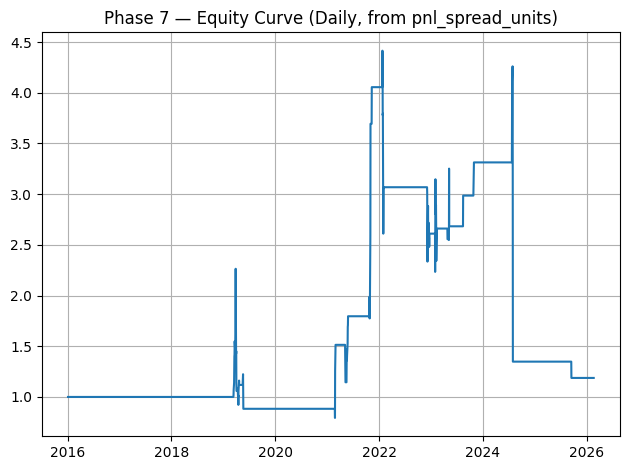

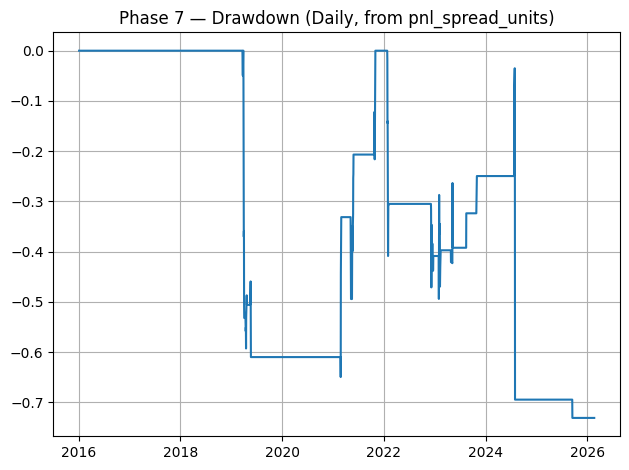

Saved figures to: /content/drive/MyDrive/pairs_trading_project/results/figures


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rets = rets_daily  # use rebuilt
port_ret = rets.mean(axis=1, skipna=True).dropna()

TRADING_DAYS = 252

def perf_stats(r: pd.Series) -> pd.Series:
    r = r.dropna()
    mean_d = r.mean()
    vol_d  = r.std(ddof=1)
    ann_ret = (1 + mean_d) ** TRADING_DAYS - 1
    ann_vol = vol_d * np.sqrt(TRADING_DAYS)
    sharpe  = (mean_d / vol_d) * np.sqrt(TRADING_DAYS) if vol_d > 0 else np.nan
    wealth = (1 + r).cumprod()
    dd = wealth / wealth.cummax() - 1
    return pd.Series({
        "start": r.index.min(),
        "end": r.index.max(),
        "n_days": len(r),
        "mean_daily": mean_d,
        "vol_daily": vol_d,
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "hit_rate": (r > 0).mean(),
        "max_drawdown": dd.min(),
        "total_return": wealth.iloc[-1] - 1,
    })

stats_port = perf_stats(port_ret)
display(stats_port.to_frame("portfolio").T)

wealth = (1 + port_ret).cumprod()
dd = wealth / wealth.cummax() - 1

plt.figure()
plt.plot(wealth.index, wealth.values)
plt.title("Phase 7 — Equity Curve (Daily, from pnl_spread_units)")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "phase7_equity_curve_rebuilt.png", dpi=160)
plt.show()

plt.figure()
plt.plot(dd.index, dd.values)
plt.title("Phase 7 — Drawdown (Daily, from pnl_spread_units)")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "phase7_drawdown_rebuilt.png", dpi=160)
plt.show()

print("Saved figures to:", FIG_DIR)

In [24]:
# Save portfolio series + stats
(port_ret.to_frame("portfolio_return")
 .to_csv(OUT_DIR / "portfolio_returns_REBUILT_daily.csv"))

stats_port.to_frame("portfolio").T.to_csv(OUT_DIR / "portfolio_perf_stats_REBUILT_daily.csv")

print("Saved:",
      OUT_DIR / "portfolio_returns_REBUILT_daily.csv",
      OUT_DIR / "portfolio_perf_stats_REBUILT_daily.csv")

Saved: /content/drive/MyDrive/pairs_trading_project/results/phase7/portfolio_returns_REBUILT_daily.csv /content/drive/MyDrive/pairs_trading_project/results/phase7/portfolio_perf_stats_REBUILT_daily.csv


In [25]:
# Trading activity
active = (pos.abs() > 0).mean().sort_values(ascending=False)
print("Fraction of days in-position per pair:")
display(active.to_frame("active_frac"))

# Portfolio active days (any pair active)
any_active = (pos.abs().sum(axis=1) > 0)
print("Any position active %:", any_active.mean())
print("Active day count:", any_active.sum(), "of", len(any_active))

Fraction of days in-position per pair:


,active_frac
EOG_FANG,0.016091
V_MA,0.013344
FCX_GOLD,0.007457


Any position active %: 0.03571428571428571
Active day count: 91 of 2548


In [26]:
# Entry/exit/cooldown/regime counts
rows = []
for pair in ["EOG_FANG","FCX_GOLD","V_MA"]:
    df = signals[pair].reindex(common_idx).copy()
    entry = pd.to_numeric(df["entry"], errors="coerce").fillna(0).astype(int)
    exit_ = pd.to_numeric(df["exit"], errors="coerce").fillna(0).astype(int)
    cooldown = pd.to_numeric(df["cooldown"], errors="coerce").fillna(0).astype(int)
    regime = df["mr_regime_final"].astype(str)

    rows.append({
        "pair": pair,
        "entry_count": int(entry.sum()),
        "exit_count": int(exit_.sum()),
        "cooldown_days": int(cooldown.sum()),
        "cooldown_frac": float(cooldown.mean()),
        "mr_regime_final_counts": regime.value_counts().to_dict()
    })

pd.DataFrame(rows)

,pair,entry_count,exit_count,cooldown_days,cooldown_frac,mr_regime_final_counts
0,EOG_FANG,7,7,0,0.0,"{'0': 2177, '1': 371}"
1,FCX_GOLD,5,5,0,0.0,"{'0': 2320, '1': 228}"
2,V_MA,6,6,0,0.0,"{'0': 2217, '1': 331}"


In [27]:
import pandas as pd
import numpy as np

rows = []
for pair in ["EOG_FANG","FCX_GOLD","V_MA"]:
    df = signals[pair].reindex(common_idx).copy()

    z = pd.to_numeric(df["z"], errors="coerce")
    entry = pd.to_numeric(df["entry"], errors="coerce").fillna(0).astype(int)
    reg1 = (df["mr_regime_final"].astype(str) == "1")

    def qstats(s):
        s = s.dropna()
        return {
            "count": len(s),
            "mean": s.mean(),
            "std": s.std(ddof=1),
            "p95": s.quantile(0.95),
            "p99": s.quantile(0.99),
            "max": s.max(),
            "min": s.min(),
        }

    rows.append({
        "pair": pair,
        "z_all": qstats(z),
        "z_regime1": qstats(z[reg1]),
        "z_entry_days": qstats(z[entry==1]),
        "entry_abs_z": z[entry==1].abs().describe().to_dict()
    })

rows

[{'pair': 'EOG_FANG',
  'z_all': {'count': 2238,
   'mean': np.float64(0.07223545497099851),
   'std': 1.3146371568848134,
   'p95': np.float64(2.0228500725014067),
   'p99': np.float64(2.933326108877375),
   'max': 4.473184905928996,
   'min': -4.39789117837497},
  'z_regime1': {'count': 371,
   'mean': np.float64(-0.15544877305348392),
   'std': 1.148205112989082,
   'p95': np.float64(1.600319292576939),
   'p99': np.float64(1.9249233142712985),
   'max': 2.0419767142856062,
   'min': -3.0345180813081947},
  'z_entry_days': {'count': 7,
   'mean': np.float64(-1.7424135564090784),
   'std': 1.6910949151785717,
   'p95': np.float64(0.826921329583173),
   'p99': np.float64(1.7989656373451182),
   'max': 2.0419767142856062,
   'min': -2.839936483923672},
  'entry_abs_z': {'count': 7.0,
   'mean': 2.3258354747763943,
   'std': 0.3011844655316458,
   'min': 2.008207901389161,
   '25%': 2.1195789272309584,
   '50%': 2.20381649707834,
   '75%': 2.4948647932908354,
   'max': 2.839936483923672

In [28]:
import numpy as np
import pandas as pd

def backtest_from_signals(df, z_enter=2.0, z_exit=0.5):
    z = pd.to_numeric(df["z"], errors="coerce")
    reg1 = (df["mr_regime_final"].astype(str) == "1")

    spread_chg = pd.to_numeric(df["spread_chg"], errors="coerce").fillna(0.0)

    pos = pd.Series(0.0, index=df.index)
    state = 0.0

    for t in range(len(df.index)):
        if not reg1.iloc[t]:
            state = 0.0  # force flat outside regime
        else:
            zi = z.iloc[t]
            if state == 0:
                if zi <= -z_enter:
                    state = +1.0
                elif zi >= +z_enter:
                    state = -1.0
            else:
                if abs(zi) <= z_exit:
                    state = 0.0
        pos.iloc[t] = state

    pnl = pos.shift(1).fillna(0.0) * spread_chg
    # scale into return-like units (same approach as before)
    scale = pd.to_numeric(df["spread"], errors="coerce").rolling(60, min_periods=20).std().replace(0, np.nan)
    ret = (pnl / scale).fillna(0.0)
    return pos, ret

def perf(r):
    r = r.dropna()
    if len(r) == 0:
        return dict()
    TRADING_DAYS = 252
    mean_d = r.mean()
    vol_d = r.std(ddof=1)
    ann_ret = (1 + mean_d) ** TRADING_DAYS - 1
    ann_vol = vol_d * np.sqrt(TRADING_DAYS)
    sharpe = (mean_d/vol_d)*np.sqrt(TRADING_DAYS) if vol_d>0 else np.nan
    wealth = (1+r).cumprod()
    dd = wealth/wealth.cummax() - 1
    return {
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": dd.min(),
        "hit_rate": (r>0).mean(),
        "nonzero_frac": (r!=0).mean()
    }

z_enters = [1.5, 2.0, 2.5, 3.0]
z_exits  = [0.25, 0.5, 1.0]

grid = []
for ze in z_enters:
    for zx in z_exits:
        pair_rets = []
        pair_pos  = []
        for pair in ["EOG_FANG","FCX_GOLD","V_MA"]:
            df = signals[pair].reindex(common_idx).copy()
            p, r = backtest_from_signals(df, z_enter=ze, z_exit=zx)
            pair_rets.append(r.rename(pair))
            pair_pos.append(p.rename(pair))
        rets_grid = pd.concat(pair_rets, axis=1).fillna(0.0)
        port = rets_grid.mean(axis=1)
        s = perf(port)
        grid.append({"z_enter": ze, "z_exit": zx, **s})

grid_df = pd.DataFrame(grid).sort_values("sharpe", ascending=False)
grid_df

,z_enter,z_exit,ann_return,ann_vol,sharpe,max_dd,hit_rate,nonzero_frac
6,2.5,0.25,0.232977,0.458129,0.457336,-0.857854,0.029827,0.049058
3,2.0,0.25,0.248909,0.596501,0.372788,-0.930235,0.043171,0.073391
7,2.5,0.50,0.105973,0.430857,0.233826,-0.857854,0.025510,0.043956
4,2.0,0.50,0.129086,0.564199,0.215239,-0.904252,0.039246,0.067504
8,2.5,1.00,0.068759,0.409267,0.162502,-0.839596,0.019231,0.032967
0,1.5,0.25,0.101657,0.986027,0.098206,-1.355007,0.080063,0.139717
5,2.0,1.00,0.052355,0.522212,0.097729,-0.888274,0.029827,0.051413
1,1.5,0.50,-0.003395,0.945896,-0.003595,-1.551030,0.072606,0.128728
2,1.5,1.00,-0.074396,0.890586,-0.086794,-1.583917,0.056515,0.100863
9,3.0,0.25,-0.064665,0.323690,-0.206500,-0.840645,0.008242,0.014914


In [29]:
import numpy as np
import pandas as pd

def backtest_config(z_enter=2.5, z_exit=0.25):
    rets_list = []
    for pair in ["EOG_FANG","FCX_GOLD","V_MA"]:
        df = signals[pair].reindex(common_idx).copy()
        pos, ret = backtest_from_signals(df, z_enter=z_enter, z_exit=z_exit)
        rets_list.append(ret.rename(pair))
    rets = pd.concat(rets_list, axis=1).fillna(0.0)
    port = rets.mean(axis=1)
    return rets, port

rets_cfg, port_cfg = backtest_config(2.5, 0.25)

# Vol targeting (rolling)
TRADING_DAYS = 252
target_ann_vol = 0.10
target_daily_vol = target_ann_vol / np.sqrt(TRADING_DAYS)

roll = 60
realized = port_cfg.rolling(roll, min_periods=20).std(ddof=1)
lev = (target_daily_vol / realized).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# cap leverage (very important)
lev_cap = 3.0
lev = lev.clip(0.0, lev_cap)

port_vt = port_cfg * lev

stats_raw = perf(port_cfg)
stats_vt  = perf(port_vt)

print("RAW:", stats_raw)
print("VOL-TARGET:", stats_vt)

print("Avg lev:", lev.mean(), "Max lev:", lev.max())

RAW: {'ann_return': np.float64(0.232977027510046), 'ann_vol': np.float64(0.4581289370456735), 'sharpe': np.float64(0.45733553759567036), 'max_dd': -0.8578535017889481, 'hit_rate': np.float64(0.029827315541601257), 'nonzero_frac': np.float64(0.04905808477237049)}
VOL-TARGET: {'ann_return': np.float64(0.04839766086365649), 'ann_vol': np.float64(0.07059519487814248), 'sharpe': np.float64(0.6695553966902127), 'max_dd': -0.08935235644882045, 'hit_rate': np.float64(0.029827315541601257), 'nonzero_frac': np.float64(0.04905808477237049)}
Avg lev: 0.041903297695256615 Max lev: 3.0


In [30]:
def backtest_no_regime(df, z_enter=2.0, z_exit=0.5):
    z = pd.to_numeric(df["z"], errors="coerce")
    spread_chg = pd.to_numeric(df["spread_chg"], errors="coerce").fillna(0.0)

    pos = pd.Series(0.0, index=df.index)
    state = 0.0

    for t in range(len(df.index)):
        zi = z.iloc[t]
        if state == 0:
            if zi <= -z_enter:
                state = +1.0
            elif zi >= +z_enter:
                state = -1.0
        else:
            if abs(zi) <= z_exit:
                state = 0.0
        pos.iloc[t] = state

    pnl = pos.shift(1).fillna(0.0) * spread_chg
    scale = pd.to_numeric(df["spread"], errors="coerce").rolling(60, min_periods=20).std().replace(0, np.nan)
    ret = (pnl / scale).fillna(0.0)
    return pos, ret

grid = []
for ze in [1.5, 2.0, 2.5, 3.0]:
    for zx in [0.25, 0.5, 1.0]:
        pair_rets = []
        for pair in ["EOG_FANG","FCX_GOLD","V_MA"]:
            df = signals[pair].reindex(common_idx).copy()
            _, r = backtest_no_regime(df, z_enter=ze, z_exit=zx)
            pair_rets.append(r.rename(pair))
        rets_grid = pd.concat(pair_rets, axis=1).fillna(0.0)
        port = rets_grid.mean(axis=1)
        s = perf(port)
        grid.append({"z_enter": ze, "z_exit": zx, **s})

pd.DataFrame(grid).sort_values("sharpe", ascending=False).head(12)

,z_enter,z_exit,ann_return,ann_vol,sharpe,max_dd,hit_rate,nonzero_frac
4,2.0,0.50,43.648096,2.598854,1.472799,-1.015818,0.379513,0.686421
5,2.0,1.00,27.452768,2.318514,1.453771,-1.012243,0.299451,0.551020
3,2.0,0.25,39.592743,2.958605,1.261047,-1.199923,0.424254,0.780612
2,1.5,1.00,30.819465,2.824378,1.233525,-4.532333,0.355965,0.662873
7,2.5,0.50,11.235560,2.066289,1.218044,-1.000261,0.297881,0.546311
1,1.5,0.50,40.011711,3.147228,1.188779,-11.214050,0.427786,0.780612
0,1.5,0.25,49.092156,3.464998,1.138360,-1.509861,0.445055,0.831240
8,2.5,1.00,4.918506,1.809303,0.986221,-1.000090,0.216641,0.404631
6,2.5,0.25,9.762163,2.421351,0.985926,-1.449038,0.360675,0.671900
10,3.0,0.50,3.405160,1.601476,0.928611,-0.992344,0.209576,0.377943


In [31]:
import numpy as np
import pandas as pd

# pnl_spread_units for each pair on each day
pnl_units = pd.concat(
    [pd.to_numeric(signals[p]["pnl_spread_units"], errors="coerce").fillna(0.0).rename(p)
     for p in ["EOG_FANG","FCX_GOLD","V_MA"]],
    axis=1
).reindex(common_idx).fillna(0.0)

pos_state = pd.concat(
    [pd.to_numeric(signals[p]["pos"], errors="coerce").fillna(0.0).rename(p)
     for p in ["EOG_FANG","FCX_GOLD","V_MA"]],
    axis=1
).reindex(common_idx).fillna(0.0)

active = (pos_state.abs() > 0).astype(int)
n_active = active.sum(axis=1)

# Allocate 1 unit of capital across active pairs only
w = active.div(n_active.replace(0, np.nan), axis=0).fillna(0.0)

# Choose a capital scaling so typical daily returns are realistic.
# Use rolling std of pnl_units when active to scale to ~1% daily vol when active.
roll = 120
pnl_port_units = (w * pnl_units).sum(axis=1)

active_mask = (n_active > 0)
scale = pnl_port_units.where(active_mask).rolling(roll, min_periods=30).std(ddof=1)
scale = scale.replace(0, np.nan)

# "Return" = pnl_units / scale; only meaningful when active, else 0
port_ret_sane = (pnl_port_units / scale).fillna(0.0)

print("Active day %:", active_mask.mean())
print("Return stats (non-zero only):")
nz = port_ret_sane[port_ret_sane != 0]
print(nz.describe())

# Performance with vol-targeting on top
def perf(r):
    r = r.dropna()
    TRADING_DAYS = 252
    mean_d = r.mean()
    vol_d = r.std(ddof=1)
    ann_ret = (1 + mean_d) ** TRADING_DAYS - 1
    ann_vol = vol_d * np.sqrt(TRADING_DAYS)
    sharpe = (mean_d/vol_d)*np.sqrt(TRADING_DAYS) if vol_d>0 else np.nan
    wealth = (1+r).cumprod()
    dd = wealth/wealth.cummax() - 1
    return {"ann_return": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": dd.min()}

print("Sane RAW:", perf(port_ret_sane))

# Vol target
target_ann_vol = 0.10
target_daily_vol = target_ann_vol / np.sqrt(252)
realized = port_ret_sane.rolling(60, min_periods=20).std(ddof=1)
lev = (target_daily_vol / realized).replace([np.inf,-np.inf], np.nan).fillna(0.0).clip(0.0, 3.0)
port_ret_sane_vt = port_ret_sane * lev

print("Sane VOL-TARGET:", perf(port_ret_sane_vt))
print("Avg lev:", lev.mean(), "Max lev:", lev.max())

Active day %: 0.03571428571428571
Return stats (non-zero only):
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64
Sane RAW: {'ann_return': np.float64(0.0), 'ann_vol': np.float64(0.0), 'sharpe': nan, 'max_dd': 0.0}
Sane VOL-TARGET: {'ann_return': np.float64(0.0), 'ann_vol': np.float64(0.0), 'sharpe': nan, 'max_dd': 0.0}
Avg lev: 0.0 Max lev: 0.0


In [32]:
import numpy as np
import pandas as pd

pnl_units = pd.concat(
    [pd.to_numeric(signals[p]["pnl_spread_units"], errors="coerce").fillna(0.0).rename(p)
     for p in ["EOG_FANG","FCX_GOLD","V_MA"]],
    axis=1
).reindex(common_idx).fillna(0.0)

pos_state = pd.concat(
    [pd.to_numeric(signals[p]["pos"], errors="coerce").fillna(0.0).rename(p)
     for p in ["EOG_FANG","FCX_GOLD","V_MA"]],
    axis=1
).reindex(common_idx).fillna(0.0)

active = (pos_state.abs() > 0).astype(int)
n_active = active.sum(axis=1)
active_mask = n_active > 0

# equal weight across active pairs only
w = active.div(n_active.replace(0, np.nan), axis=0).fillna(0.0)

pnl_port_units = (w * pnl_units).sum(axis=1)

# ---- robust scale on ACTIVE days only, then forward-fill ----
roll = 120
minp = 5

abs_pnl_active = pnl_port_units.abs().where(active_mask)

# MAD-ish scale: median(|x|) / 0.6745 approximates std if normal-ish
scale = (abs_pnl_active.rolling(roll, min_periods=minp).median() / 0.6745)

# forward-fill scale so every active day has a scale
scale = scale.ffill()

# if still NaN at the very beginning, fall back to global median of active abs pnl
fallback = abs_pnl_active.median() / 0.6745
scale = scale.fillna(fallback)

# build return series: only nonzero when active
port_ret_sane = (pnl_port_units / scale).where(active_mask, 0.0)

print("Active day %:", active_mask.mean())
nz = port_ret_sane[port_ret_sane != 0]
print("Non-zero count:", len(nz))
print(nz.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

def perf(r):
    r = r.dropna()
    TRADING_DAYS = 252
    mean_d = r.mean()
    vol_d = r.std(ddof=1)
    ann_ret = (1 + mean_d) ** TRADING_DAYS - 1
    ann_vol = vol_d * np.sqrt(TRADING_DAYS)
    sharpe = (mean_d/vol_d)*np.sqrt(TRADING_DAYS) if vol_d>0 else np.nan
    wealth = (1+r).cumprod()
    dd = wealth/wealth.cummax() - 1
    return {"ann_return": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": dd.min()}

print("Sane RAW:", perf(port_ret_sane))

# vol target on top
target_ann_vol = 0.10
target_daily_vol = target_ann_vol / np.sqrt(252)
realized = port_ret_sane.rolling(60, min_periods=10).std(ddof=1)
lev = (target_daily_vol / realized).replace([np.inf,-np.inf], np.nan).fillna(0.0).clip(0.0, 3.0)
port_ret_sane_vt = port_ret_sane * lev

print("Sane VOL-TARGET:", perf(port_ret_sane_vt))
print("Avg lev:", lev.mean(), "Max lev:", lev.max())

Active day %: 0.03571428571428571
Non-zero count: 78
count    74.000000
mean           inf
std            NaN
min      -6.380935
1%       -4.856532
5%       -2.560294
50%       0.302520
95%            inf
99%            NaN
max            inf
dtype: float64
Sane RAW: {'ann_return': np.float64(inf), 'ann_vol': np.float64(nan), 'sharpe': nan, 'max_dd': np.float64(-inf)}
Sane VOL-TARGET: {'ann_return': np.float64(0.017689995587425456), 'ann_vol': np.float64(0.06587579850623045), 'sharpe': np.float64(0.26619728733645603), 'max_dd': -0.18073329129786575}
Avg lev: 0.00549315275552089 Max lev: 2.896259773060621


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [33]:
from pathlib import Path

for pat in ["*prices*.csv", "*price*.csv", "*adjclose*.csv", "*returns*.csv", "*daily*.csv", "*ohlc*.csv"]:
    hits = list(PROJECT_ROOT.rglob(pat))
    if hits:
        print("\n", pat)
        for h in hits[:25]:
            print(h)


 *prices*.csv
/content/drive/MyDrive/pairs_trading_project/data/raw/stock_prices_2026_02_22.csv

 *price*.csv
/content/drive/MyDrive/pairs_trading_project/data/raw/stock_prices_2026_02_22.csv
/content/drive/MyDrive/pairs_trading_project/results/statistics/price_spikes_top5_each.csv

 *returns*.csv
/content/drive/MyDrive/pairs_trading_project/results/statistics/pair_returns_after_costs.csv
/content/drive/MyDrive/pairs_trading_project/results/phase7/pair_returns_REBUILT_from_signals.csv
/content/drive/MyDrive/pairs_trading_project/results/phase7/pair_returns_DAILY_from_pnl_spread_units.csv
/content/drive/MyDrive/pairs_trading_project/results/phase7/portfolio_returns_REBUILT_daily.csv

 *daily*.csv
/content/drive/MyDrive/pairs_trading_project/results/phase7/portfolio_returns_REBUILT_daily.csv
/content/drive/MyDrive/pairs_trading_project/results/phase7/portfolio_perf_stats_REBUILT_daily.csv
